<a href="https://colab.research.google.com/github/Dharshini-git969/EDA/blob/main/SUCCESS_PROJECT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim

# Set paths
image_paths = ['nature.jpg', 'nature_3.jpg', 'nature_4.jpg']
image_size = 256  # Resize to 256x256

def load_and_preprocess_images(paths):
    X, Y = [], []
    for path in paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        lab = rgb2lab(img)
        L = lab[:, :, 0]
        ab = lab[:, :, 1:] / 128.0  # Normalize A & B
        X.append(L.reshape(image_size, image_size, 1) / 100.0)  # Normalize L
        Y.append(ab)
    return np.array(X), np.array(Y)

X, Y = load_and_preprocess_images(image_paths)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [ ]:
def build_colorization_model():
    inputs = Input(shape=(image_size, image_size, 1))

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(2)(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(2)(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)

    # Decoder
    up1 = UpSampling2D(2)(conv3)
    up1 = Conv2D(128, 3, activation='relu', padding='same')(up1)

    up2 = UpSampling2D(2)(up1)
    up2 = Conv2D(64, 3, activation='relu', padding='same')(up2)

    output = Conv2D(2, 3, activation='tanh', padding='same')(up2)  # Output ab

    model = Model(inputs=inputs, outputs=output)
    return model

model = build_colorization_model()
model.compile(optimizer=Adam(), loss='mse')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 2)    │         1,154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,650 (2.82 MB)

 Trainable params: 739,650 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, Y_train, epochs=300, batch_size=2, validation_data=(X_test, Y_test))


Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0451 - val_loss: 0.1031
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0980 - val_loss: 0.0138
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0370 - val_loss: 0.0133
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0413 - val_loss: 0.0134
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0419 - val_loss: 0.0135
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0403 - val_loss: 0.0140
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0373 - val_loss: 0.0175
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.0350 - val_loss: 0.0275
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.0373 - val_loss: 0.0221
Epoch 10/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0346 - val_loss: 0.0168
Epoch 11/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0334 - val_loss: 0.0150
Epoch 12/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0332 - val_loss: 0.0154
Epoch 13/30

In [ ]:
def display_and_save_output(index, model, X, Y, name):
    # Input L and true ab
    L_input = X[index].reshape(1, image_size, image_size, 1)
    ab_true = Y[index]
    L_original = X[index].reshape(image_size, image_size, 1)

    # Predict ab
    ab_pred = model.predict(L_input)[0]

    # Convert to RGB
    original_rgb = lab2rgb(np.concatenate([L_original * 100, ab_true * 128], axis=-1))
    gray_img = L_original.reshape(image_size, image_size)  # Grayscale L
    predicted_rgb = lab2rgb(np.concatenate([L_original * 100, ab_pred * 128], axis=-1))

    # Plot all 3
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(original_rgb)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(gray_img, cmap='gray')
    axs[1].set_title("Grayscale Image")
    axs[1].axis('off')

    axs[2].imshow(predicted_rgb)
    axs[2].set_title("Predicted (Colorized) Image")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Save output
    output_path = f'combined_{name}.png'
    plt.imsave(output_path, predicted_rgb)
    print(f"Saved Predicted Image: {output_path}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


<ipython-input-6-da1b1c5ae1e9>:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 22 negative Z values that have been clipped to zero
  predicted_rgb = lab2rgb(np.concatenate([L_original * 100, ab_pred * 128], axis=-1))


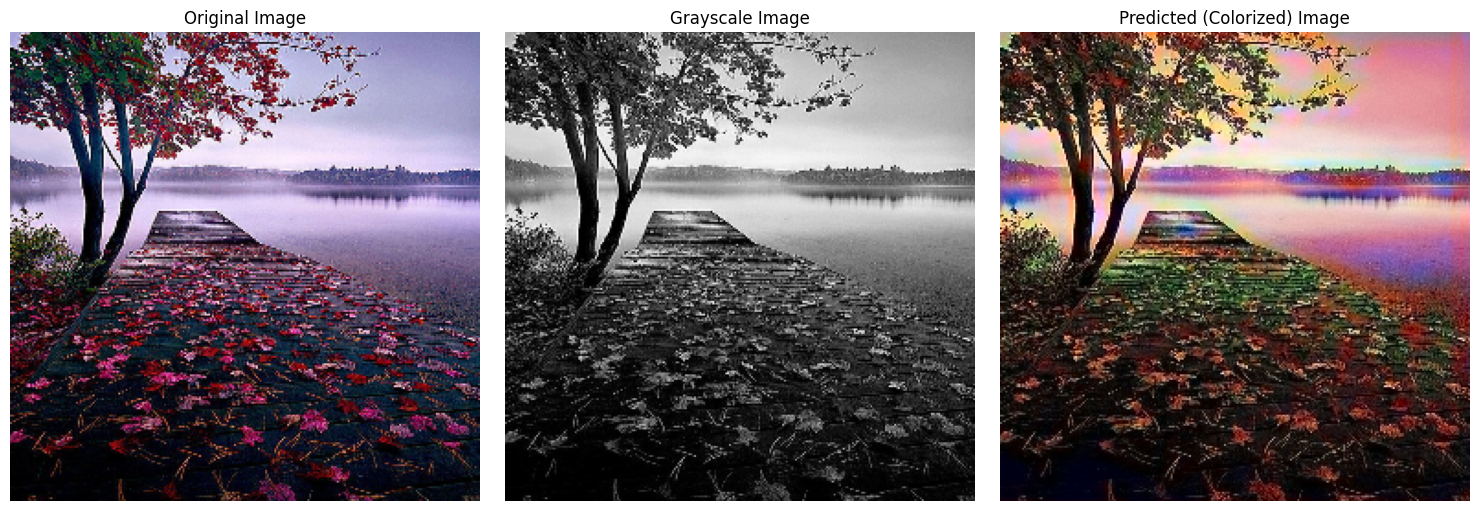

Saved Predicted Image: combined_nature.jpg.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


<ipython-input-6-da1b1c5ae1e9>:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9 negative Z values that have been clipped to zero
  predicted_rgb = lab2rgb(np.concatenate([L_original * 100, ab_pred * 128], axis=-1))


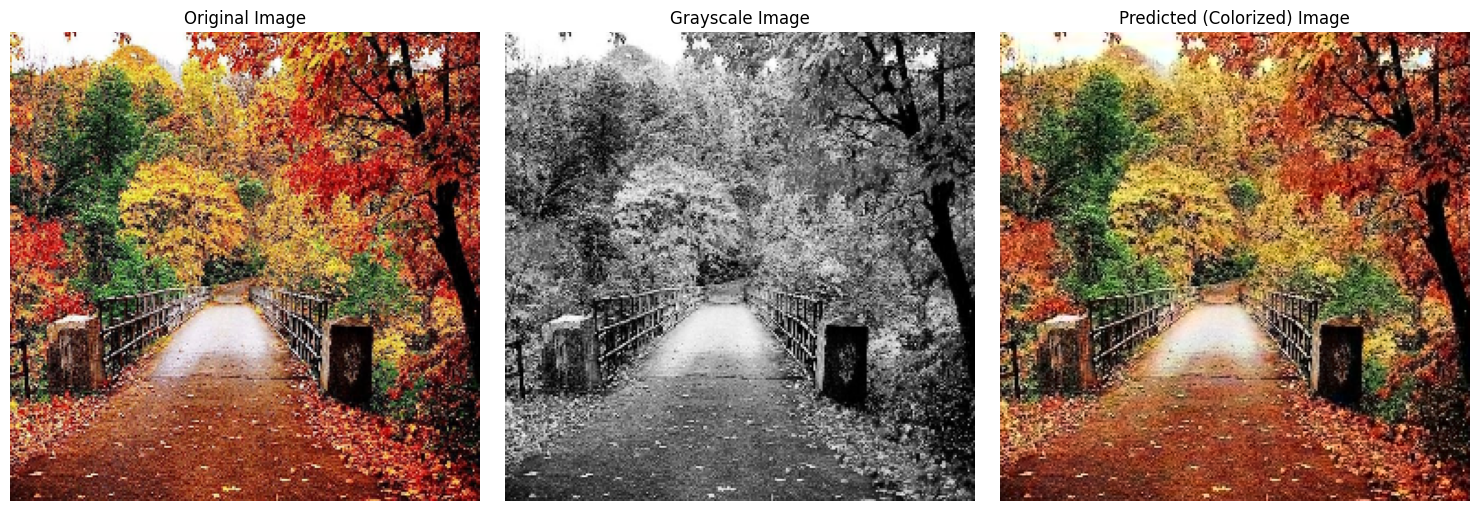

Saved Predicted Image: combined_nature_3.jpg.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


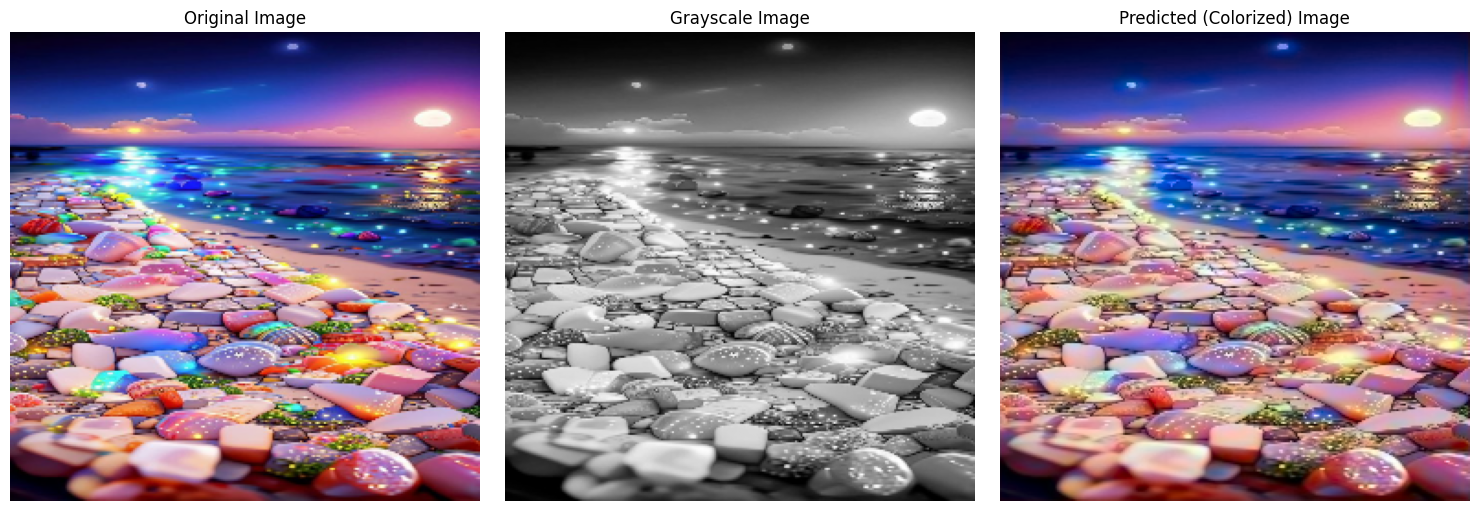

Saved Predicted Image: combined_nature_4.jpg.png


In [ ]:
for i, name in enumerate(image_paths[-3:]):
    display_and_save_output(i, model, X, Y, name)


In [ ]:
def calculate_ssim(model, X, Y, names):
    for i in range(len(X)):
        L = X[i].reshape(1, image_size, image_size, 1)
        ab_pred = model.predict(L)[0]
        L_img = X[i].reshape(image_size, image_size, 1)
        Y_true = Y[i]

        pred_rgb = lab2rgb(np.concatenate([L_img * 100, ab_pred * 128], axis=-1)) # Use lab2rgb consistently
        true_rgb = lab2rgb(np.concatenate([L_img * 100, Y_true * 128], axis=-1))   # Use lab2rgb consistently

        pred_gray = rgb2gray(pred_rgb)
        true_gray = rgb2gray(true_rgb)

        # Add data_range=1.0 since the pixel values are between 0 and 1
        score = ssim(true_gray, pred_gray, data_range=1.0)
        print(f"SSIM for {names[i]}: {score:.4f}")

calculate_ssim(model, X, Y, image_paths)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
SSIM for nature.jpg: 0.9872

<ipython-input-9-a94e931e73b2>:8: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 22 negative Z values that have been clipped to zero
  pred_rgb = lab2rgb(np.concatenate([L_img * 100, ab_pred * 128], axis=-1)) # Use lab2rgb consistently



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<ipython-input-9-a94e931e73b2>:8: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9 negative Z values that have been clipped to zero
  pred_rgb = lab2rgb(np.concatenate([L_img * 100, ab_pred * 128], axis=-1)) # Use lab2rgb consistently


SSIM for nature_3.jpg: 0.9962
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
SSIM for nature_4.jpg: 0.9932
